# Introduction to the Experiment

Parzen Window is a non-parametric statistical method used to estimate probability density functions. Unlike parametric methods, Parzen Window does not assume that the data follows a particular distribution. Instead, it estimates the density function based on the sample points themselves. The fundamental idea of the Parzen Window method is to place a kernel (window function) around each data point and estimate the probability density by averaging the kernel values.

The experiment will use 5-fold cross-validation to evaluate the accuracy.

The Parzen Window experiment focuses on the influence of the kernel bandwidth \(h\) on classification accuracy. The bandwidth \(h\) controls the smoothness of the kernel function, and different \(h\) values directly affect the model’s ability to fit the data distribution. By adjusting the value of \(h\), the experiment identifies the optimal bandwidth.


# Dataset

This experiment is based on the **Iris.data** dataset, which is a classic dataset widely used in pattern recognition and machine learning. The dataset was introduced by British statistician and biologist Ronald A. Fisher in 1936. The Iris dataset contains 150 samples from three different species of iris flowers, with 50 samples for each species. The species are: 
- **Iris-setosa**
- **Iris-versicolor**
- **Iris-virginica**. 

Each sample includes four features describing the morphological characteristics of the flowers:
- **Sepal Length**
- **Sepal Width**
- **Petal Length**
- **Petal Width**

All four features are measured in centimeters. Each sample in the dataset is associated with a **class label** representing the species of the iris flower.

In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import timeit
from math import *

from click import style
from networkx.algorithms.bipartite.basic import color

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

## Data Visualization

In [162]:
def two_d_plot(filename) -> None:  # To check the general properties of the dataset in 2D (Additional task)
    data = pd.read_csv(filename, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])  # Read the CSV file, and assign column names for the dataset (sepal length, sepal width, petal length, petal width, class)
    g = sns.pairplot(data, hue='class', height=2, palette='colorblind')  # Create a pair plot of all the features, colored by class (Setosa, Versicolor, Virginica), use the 'colorblind' palette, and set the plot size to height=2
    g.fig.suptitle('Feature Relationship in Two-Dimensional', fontweight='bold', x=0.44, y=1.02)
    g.fig.set_dpi(300)
    plt.show()  # Display the plot

In [163]:
def four_d_plot(p1, p2, p3, p4) -> None:  # To check the general properties of the dataset in 4D (Additional task)
    fig = plt.figure(figsize=(7, 7), dpi=300)  # Create a new figure for plotting
    ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot in the figure (1 row, 1 column, 1st subplot)
    x = p1.astype(float)  # sepal length, x-axis
    y = p2.astype(float)  # sepal width, y-axis
    z = p3.astype(float)  # petal length, z-axis
    c = p4.astype(float)  # petal width, represented by color
    img = ax.scatter(x, y, z, c=c, cmap='cool')  # The 4D datasets will be shown in the 3D coordinate with color gradient
    fig.colorbar(img, cax=fig.add_axes([0.97, 0.2, 0.03, 0.6]))  # Add a color bar to indicate the values represented by the color gradient
    # Add axis labels
    ax.set_xlabel('sepal length', fontweight='bold')  # Set label for the x-axis
    ax.set_ylabel('sepal width', fontweight='bold')  # Set label for the y-axis
    ax.set_zlabel('petal length', fontweight='bold')  # Set label for the z-axis
    plt.suptitle('Feature Relationship in Four-Dimensional', fontweight='bold', y=0.92)
    plt.show()  # Display the plot

## Data Processing

In [7]:
class DataProcessing:  # Class for data pre-processing
    def __init__(self) -> None:
        self.filename = 'iris.data'  # Dataset folder name
        # Predefined parameters
        self.line_comp = []
        self.iris_list = []

    def load_data(self) -> list:  # Method to load the dataset and store them in a list
        with open(self.filename) as f:
            for line in f:
                text_lines = line.strip()
                line_comp = text_lines.split(',')
                self.iris_list.append(line_comp)
        return self.iris_list

    def shuffle(self) -> list:  # Method to shuffle the stored dataset
        random.seed(97)  # Define the seed value first to keep the shuffled data same
        random.shuffle(self.iris_list)  # Shuffle the list
        return self.iris_list

    def separate_data(self) -> tuple[list, list, list, list, list]:  # Method to separate the dataset into five parts for 5-fold cross validation
        length = int(len(self.iris_list) / 5)  # Cutting length of the list
        data = [self.iris_list[i * length:(i + 1) * length] for i in range(5)]
        return data[0], data[1], data[2], data[3], data[4]
    
    def data_analyzer(self, info) -> None:  # Method to plot the 2D and 4D figures of the given dataset to analyze the properties
        np_info = np.array(info)
        sepal_length = np_info[:, 0]
        sepal_width = np_info[:, 1]
        petal_length = np_info[:, 2]
        petal_width = np_info[:, 3]
        four_d_plot(sepal_length, sepal_width, petal_length, petal_width)
        two_d_plot(self.filename)

    @staticmethod
    def combine_train(ind, total_data) -> tuple[list, list]:  # Method to separate combined train sets and a test set
        test = total_data[ind]
        train = [item for i, subset in enumerate(total_data) if i != ind for item in subset]
        return train, test

    @staticmethod
    def separate_class(dataset) -> tuple[list, list, list]:  # Method to separate dataset into three given classes
        setosa = []
        versicolor = []
        virginica = []
        for info in dataset:
            if info[4] == 'Iris-setosa':
                setosa.append(info)
            elif info[4] == 'Iris-versicolor':
                versicolor.append(info)
            else:
                virginica.append(info)
        return setosa, versicolor, virginica

    @staticmethod
    def numeric_n_name(nested_list) -> tuple[list, list]:  # Method to separate the numeric data and class_names
        num_list = []
        class_list = []
        for instance in nested_list:
            num_data = instance[:4]  # Extract the numeric data
            class_name = instance[4:]  # Extract the class names of the data sets
            num_list.append(num_data)
            class_list += class_name
        return num_list, class_list  # Numeric data can be converted into numpy array

    @staticmethod
    def prior_prob(dataset) -> tuple[
        float, float, float]:  # Method to calculate the prior probabilities of each class
        prior_prob_se = len(dataset[0]) / (len(dataset[0]) + len(dataset[1]) + len(dataset[2]))  # Setosa
        prior_prob_ve = len(dataset[1]) / (len(dataset[0]) + len(dataset[1]) + len(dataset[2]))  # Versicolor
        prior_prob_vi = len(dataset[2]) / (len(dataset[0]) + len(dataset[1]) + len(dataset[2]))  # Virginica
        return prior_prob_se, prior_prob_ve, prior_prob_vi

## Computing the High-Dimensional Kernel Window

In [8]:
def multivariate_normal_kernel(x, xi, h, cov):  # Kernel function for datasets higher than 1D
    ###############################################################################################################
    #                                   YOU NEED FILL FOLLOWING CODES:
    det_cov = np.linalg.det(cov)  # Determinant of the covariance matrix. Tip: use np.linalg.det()
    inv_cov = np.linalg.inv(cov)  # Inverse of the covariance matrix. Tip: np.linalg.inv()
    u = (x - xi) / h  # Compute the distance, math is (x - xi)/h. You may need to turn it into matrix
    numer = np.exp(-0.5 * (u @ inv_cov @ u.T))  # Numerator of the multivariate gaussian distribution, math is pow(e, ( -0.5 * u * inv_cov * u.T))
    denom = np.power((2 * np.pi), (len(x) / 2)) * np.sqrt(det_cov)  # Denominator of the multivariate gaussian distribution, math is pow(pow(2*pi, len(x)) * det_cov, 1/2)
    kernel = numer / denom  # numer / denom
    ###############################################################################################################
    return kernel

### Instructions for Filling Code

According to:

$P(\mathbf{x} | \omega_i) = \frac{1}{(2 \pi)^{d/2} |\Sigma_i|^{1/2}} \exp \left[ -\frac{1}{2} (\mathbf{x} - \mu_i)^T \Sigma_i^{-1} (\mathbf{x} - \mu_i) \right]$

- Use `np.linalg.det()` to calculate the determinant of the covariance matrix.
- Use `np.linalg.inv()` to calculate the inverse of the covariance matrix.
- Compute the Euclidean distance between the test set and the training set.
- Compute the numerator part of the Gaussian discriminant function.
- Compute the denominator part of the Gaussian discriminant function.
- Calculate the probability.

## Computing One-Dimensional Kernel Window

In [9]:
def normal_kernel(x, xi, h):  # Kernal function for 1D datasets
    ###############################################################################################################
    #                                   YOU NEED FILL FOLLOWING CODES:
    u = (x - xi) / h  # Compute the distance, math is (x - xi) / h
    kernel = np.exp(-0.5 * np.power(u, 2)) / np.sqrt(2 * np.pi)  # math is :exp(-(abs(u) ** 2) / 2) / (sqrt(2 * pi)), use numpy methods will be helpful
    ###############################################################################################################
    return kernel

### Instructions for Filling Code

According to:

$H(\mathbf{u}) = \frac{1}{(2 \pi)^{d/2}} \exp \left( - \frac{\|\mathbf{u}\|^2}{2} \right)$

- Compute the Euclidean distance between the test set and the training set.
- Calculate the probability.

## Computing Parzen Window

In [10]:
def parzen_window(test, train, h, d):  # Parzen Window function to output the conditional probability
    ###############################################################################################################
    #                                   YOU NEED FILL FOLLOWING CODES:
    cov = np.identity(d)  # Create an identity matrix scaled with the dimension of the dataset for the covariance matrix. Tip: use np.identity()
    ###############################################################################################################
    if d == 1:  # For 1D, apply the normal distribution
        p = normal_kernel(test, train, h) / h
        return p
    else:  # For higher dimension, apply the multivariate normal distribution
        p = multivariate_normal_kernel(test, train, h, cov) / np.power(h, d)
        return p

### Instructions for Filling Code

Use `np.identity()` to generate a \(d\)-dimensional identity matrix.

## Computing Prediction

In [11]:
def pz_predict(x_len, np_array) -> list:  # To find the predicted class of the test set
    x_pred = []
    for i in range(x_len):
        max = np.max(np_array[:, i])  # Get the maximum probability in the ith column (ith data of x)
        if max == np_array[0][i]:  # If 'max' is equal to the ith value in setosa array
            pred = 'Iris-setosa'
        elif max == np_array[1][i]:  # If 'max' is equal to the ith value in versicolor array
            pred = 'Iris-versicolor'
        else:  # If 'max' is equal to the ith value in virginica array
            pred = 'Iris-virginica'
        x_pred.append(pred)  # Store the predicted class in the order of the test datasets
    return x_pred

In [12]:
def pz_accuracy(pred_class, class_x) -> float:  # To obtain the accuracy of the predicted result
    acc = 0  # Initialize the accuracy
    for ind, pred in enumerate(pred_class):
        if pred == class_x[ind]:  # Compare the predicted classes with the actual classes of the test set
            acc += 1  # Increase the accuracy parameter if it is correct
        else:
            pass  # If not correct, pass
    return (acc / len(pred_class) * 100) if len(pred_class) > 0 else 0

## Main Part

In [164]:
iris = DataProcessing()  # Define Class Data_process()
irist_data = iris.load_data()  # Load the iris dataset
div_data = iris.numeric_n_name(irist_data)  # Separate numeric dataset and class names
init_data = iris.shuffle()  # Shuffle the dataset
five_data = iris.separate_data()

## Data Analysis

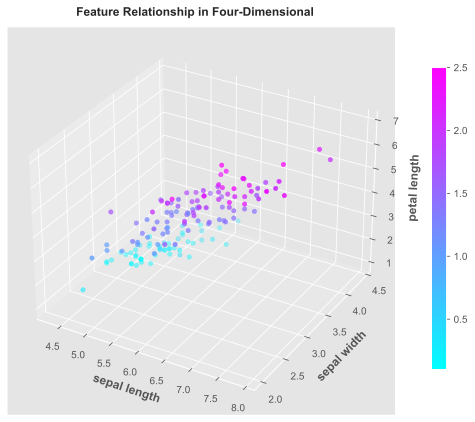

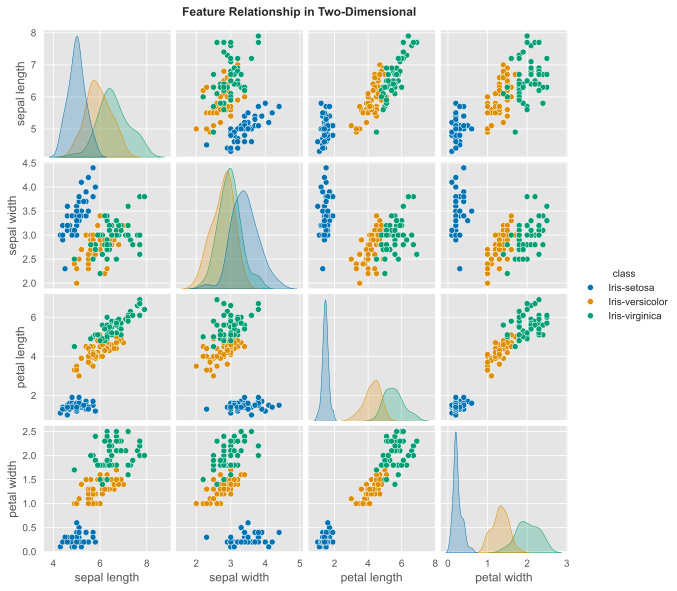

In [165]:
iris.data_analyzer(div_data[0]) # Check the general properties of the dataset

## Running of Parzen Window

In [166]:
# Initialize lists for checking the results
h_list = []
Lh_list = []
acc_list = []

start = timeit.default_timer()  # Start timer to count the running time of Parzen Window Method

# for h in range(1, 4): # 'for loop' condition to compare the program time of Pazen Window and MQDF
for h in np.arange(0.2, 3.0, 0.1):  # Find the optimal kernel via Changing the h value
    opt_size = 0  # To find the optimal kernel size
    sum_avg_acc = 0  # To calculate the average accuracy of 5-fold cross validation
    for index in range(len(five_data)):  # 5-fold Cross-Validation
        total_subset = iris.combine_train(index, five_data)  # Index denotes the array for testing
        sep_dataset = iris.separate_class(total_subset[0])  # Return separated train datasets by three classes
        sep_data = [sep_dataset[0], sep_dataset[1], sep_dataset[2]]
        prior_prob = iris.prior_prob(sep_dataset)  # Calculate the prior probabilties of three classes
        # Convert the three train datasets into numpy array
        np_se = np.array(iris.numeric_n_name(sep_data[0])[0])
        np_ver = np.array(iris.numeric_n_name(sep_data[1])[0])
        np_vir = np.array(iris.numeric_n_name(sep_data[2])[0])
        # Prepare the train dataset by converting the numbers in str to float
        train = [np_se.astype(float), np_ver.astype(float), np_vir.astype(float)]

        d = len(np_se[0])  # Dimension of the dataset

        # Prepare the test dataset
        x, class_x = iris.numeric_n_name(total_subset[1])  # Numeric data of test set and real class names of each test set
        np_x = np.array(x).astype(float)
        x_len = len(np_x)
        # To store the conditional probability of each test data
        p_se = []
        p_ver = []
        p_vir = []
        cn = 0  # Counter to check the category of the train dataset in for loop

        # Start the Parzen Window algorithm
        for name in train:  # For three class names
            for x in np_x:  # For each data list of the test set
                p_x = 0  # define the initial probability of x
                for x_i in name:  # For each data list of the train set
                    con_prob = parzen_window(x, x_i, h, d)  # Compute the kernel function of PZ
                    p_x += con_prob  # Add the output of the kernel function for every train data lists
                p_xw = p_x / len(name)  # Compute the conditional probability of a test data
                opt_size += log10(p_xw)  # Maximum log-likelihood estimation to find the optimal kernel size

                # Add the probability into its category
                if cn == 0:
                    p_se.append(p_xw * prior_prob[0])  # Posterior probability of x in Setosa
                elif cn == 1:
                    p_ver.append(p_xw * prior_prob[1])  # Posterior probability of x in Versicolor
                else:
                    p_vir.append(p_xw * prior_prob[2])  # Posterior probability of x in Virginica
            cn += 1  # Count when the loop of one category is finished

        prob_array = np.array([p_se, p_ver, p_vir])  # Combine the computed posterior probability of three classes

        pred_class = pz_predict(x_len, prob_array)  # Obtain the predicted results of Parzen Window Method

        pz_acc = pz_accuracy(pred_class, class_x)  # Calculate the classification accuracy
        sum_avg_acc += pz_acc

    avg_acc = sum_avg_acc / len(five_data)  # Average accuracy

    Lh = opt_size / len(five_data)  # Compute the average log-likelihood value of the chosen h

    print(f'Average accuracy of 5-fold cross-validation when h = {h:.1f} : {avg_acc}')
    print('--------------------------------------------------------------------------------')
    
    # Store the results to plot on graphs
    h_list.append(h)
    Lh_list.append(Lh)
    acc_list.append(avg_acc)
    
stop = timeit.default_timer()  # Stop timer for the running time of Parzen Window algortihm
print(f'Running time of Parzen Window with 5-fold cross validation: {stop - start}\n')

Average accuracy of 5-fold cross-validation when h = 0.2 : 96.00000000000001
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.3 : 96.66666666666667
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.4 : 96.00000000000001
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.5 : 95.33333333333334
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.6 : 96.0
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.7 : 96.0
--------------------------------------------------------------------------------
Average accuracy of 5-fold cross-validation when h = 0.8 : 95.33333333333334
-

## Visualization of the Average Classification Accuracy in Terms of h

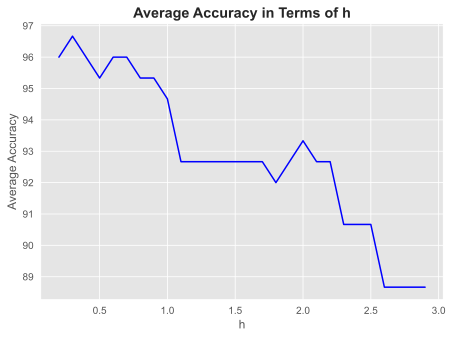

In [172]:
x = np.array(h_list)
y = np.array(acc_list)
y2 = np.array(Lh_list)

plot1 = plt.figure(tight_layout=True, dpi=300)
plt.plot(x, y, label='Accuracy', color='blue')
plt.xlabel('h')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy in Terms of h', fontweight='bold')
plt.show()

## Visualization of the Result of Maximum Likelihood Estimation of h

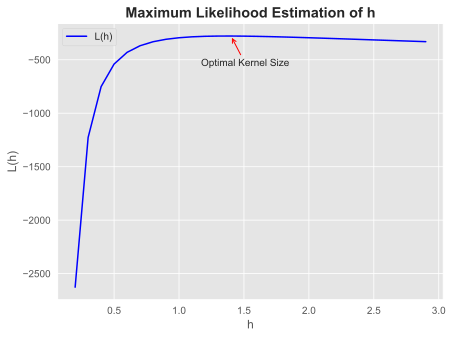

In [173]:
plot2 = plt.figure(tight_layout=True, dpi=300)
plt.plot(x, y2, label='L(h)', color='blue')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.title('Maximum Likelihood Estimation of h', fontweight='bold')

ymax = max(y2)
xpos = np.where(y2 == ymax)
xmax = x[xpos].item()
opt_avg_acc = y[xpos].item()

plt.annotate('Optimal Kernel Size',
             xy=(xmax, ymax),
             xycoords='data',
             xytext=(-30, -30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red', linewidth=1))
plt.legend()
plt.show()

## Print Best Result

In [169]:
print(f'Optimal Kernel Size: {xmax:.1f}')
print(f'Average accuracy when h = {xmax:.1f} : {opt_avg_acc}')
print('--------------------------------------------------------------------------------')

ymax = max(y)
xpos = np.where(y == ymax)
xmax = x[xpos].item()
opt_avg_acc = y[xpos].item()

print(f'Highest average accuracy: {xmax:.1f}')
print(f'Average accuracy when h = {xmax:.1f} : {opt_avg_acc}')

Optimal Kernel Size: 1.4
Average accuracy when h = 1.4 : 92.66666666666666
--------------------------------------------------------------------------------
Highest average accuracy: 0.3
Average accuracy when h = 0.3 : 96.66666666666667
